# Détection de fraude bancaire
### Big Data Mining M2 SISE : Pauline Lainé - Khanh Hoàng Lê

## 1. Introduction

Lorsqu'un client paye par chèque, il se peut que celui-ci ne paye jamais son panier, nous sommes alors dans le cas d'une fraude. Deux raisons peuvent être dû à une fraude. 

Le premier cas, c'est lorsque nous sommes dans le cas d'un chèque dit impayé, ce cas de figure apparait lorsque la personne ne possède pas le solde sur son compte en banque. L'autre cas de figure c'est lorsque nous avons à faire à un faux chèque. Un faux chèque peut se caractériser par une fausse identité ou lorsque le CMC7 est incorrect. Le CMC7 est une série de Caractères Magnétiques Codés à 7 bâtonnets situé en bas d'un chèque.

Sur une période de 10 mois, ces fraudes se compte au nombre de 20 000 soit 0.6% des transactions réalisées, réprésentant un chiffre d'affaires de 2 millions d'euros qui équivaut à 1.1% du chiffre d'affaires total de l'enseigne. C'est un chiffre d'affaires perdu non négligable. 

Notre étude va alors se porter sur la détection des fraudes par chèque dans un contexte déséquilibré.

## 2. Les données

Les données que nous allons utiliser provienne d'une enseigne de grande distribustion et d'organismes bancaires tels que la FNCI et la Banque de France. Nous avons une ligne par transaction sur la période du 21/03/2016 au 19/10/2016 soit une période de 7 mois. Chaque transaction est décrite par les 23 variables suivantes : 

- ZIBZIN : identifiant bancaire relatif à la personne
- IDAvisAutorisAtionCheque : identifiant de la transaction en cours
- Montant : montant de la transaction
- DateTransaction : date de la transaction
- CodeDecision : il s’agit d’une variable qui peut prendre ici 4 valeurs
    - 0 : la transaction a été acceptée par le magasin
    - 1 : la transaction et donc le client fait partie d’une liste blanche (bons payeurs). Aucun dans cette base de données
    - 2 : le client fait d’une partie d’une liste noire, son historique indique c'est un mauvais payeur (des impayés en cours ou des incidents bancaires en cours), sa transaction est alors automatiquement refusée
    - 3 : client ayant était arrêté par le système par le passé pour une raison plus ou moins fondée
- VérifianceCPT1 : nombre de transactions effectuées par le même identifiant bancaire au cours du même jour
- VérifianceCPT2 : nombre de transactions effectuées par le même identifiant bancaire au cours des trois derniers jours
- VérifianceCPT3 : nombre de transactions effectuées par le même identifiant bancaire au cours des sept derniers jours
- D2CB : durée de connaissance du client (par son identifiant bancaire), en jours. Pour des contraintes légales, cette durée de connaissance ne peut excéder deux ans
- ScoringFP1 : score d’anormalité du panier relatif à une première famille de produits (ex : denrées alimentaires)
- ScoringFP2 : score d’anormalité du panier relatif à une deuxième famille de produits(ex : électroniques)
- ScoringFP3 : score d’anormalité du panier relatif à une troisième famille de produits (ex : autres)
- TauxImpNb_RB : taux impayés enregistrés selon la région où a lieu la transaction
- TauxImpNB_CPM : taux d’impayés relatif au magasin où a lieu la transaction
- EcartNumCheq : différence entre les numéros de chèques
- NbrMagasin3J : nombre de magasins différents fréquentés les 3 derniers jours
- DiffDateTr1 : écart (en jours) à la précédente transaction
- DiffDateTr2 : écart (en jours) à l’avant dernière transaction
- DiffDateTr3 : écart (en jours) à l’antépénultième transaction
-  CA3TRetMtt : montant des dernières transactions + montant de la transaction en cours
- CA3TR : montant des trois dernières transactions
- Heure : heure de la transaction
- FlagImpaye : acception (0) ou refus de la transaction (1)

Cette dernière variable "FlagImpaye" est celle que nous cherchons à prédire. La classe 0 correspondant aux transactions normales et acceptées et la classe 1 correspond aux fraudes, les transactions qui sont refusées.

Voyons à présent de plus près à quoi ressemble nos données.

#### Importation des librairies 

In [2]:
import numpy as np
import pandas as pd
import missingno as mn
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.svm import LinearSVC
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,TimeSeriesSplit, cross_val_score,cross_val_predict
from sklearn.metrics import recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from time import time
import seaborn as sns
import imblearn
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
print(imblearn.__version__)

0.7.0


### 2.1. Importation du jeu de données 

In [3]:
import os
#os.chdir("D:/OneDrive/Documents/COURS/M2 SISE/Big Data Mining/Projet")
#df = pd.read_csv("dataproject.csv",encoding="utf-8",header=0, sep =";",decimal=',')
df =pd.read_csv("/Users/hoangkhanhle/Desktop/School/Master 2/Big Data/dataproject.csv",encoding="utf-8",header=0, sep =";",decimal=',')

In [26]:
df.head()

,ZIBZIN,IDAvisAutorisAtionCheque,MontAnt,DAteTrAnsAction,CodeDecision,VerifiAnceCPT1,VerifiAnceCPT2,VerifiAnceCPT3,D2CB,ScoringFP1,...,TAuxImpNB_CPM,EcArtNumCheq,NbrMAgAsin3J,DiffDAteTr1,DiffDAteTr2,DiffDAteTr3,CA3TRetMtt,CA3TR,Heure,FlAgImpAye
0,A034010041908012010710730,71051532,40.17,2016-03-21 07:47:38,0,1,1,1,535,0.0,...,21.834061,0,1,4.0,4.0,4.0,40.17,0.0,28058,0
1,A035010041908006493331734,71051533,20.00,2016-03-21 08:04:57,0,0,0,0,358,0.0,...,12.586532,0,1,4.0,4.0,4.0,20.00,0.0,29097,0
2,A013010003908005150136747,71051534,35.00,2016-03-21 08:06:45,0,0,0,0,199,0.0,...,39.274924,0,1,4.0,4.0,4.0,35.00,0.0,29205,0
3,A013010041908025639221029,71051536,20.00,2016-03-21 08:11:38,0,0,0,0,38,0.0,...,39.274924,0,1,4.0,4.0,4.0,20.00,0.0,29498,0
4,A013010003908005556100283,71051538,20.00,2016-03-21 08:17:11,0,0,0,0,26,0.0,...,39.274924,0,1,4.0,4.0,4.0,20.00,0.0,29831,0


In [27]:
print(np.shape(df))
print(df.info())

(2231369, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231369 entries, 0 to 2231368
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ZIBZIN                    object 
 1   IDAvisAutorisAtionCheque  int64  
 2   MontAnt                   float64
 3   DAteTrAnsAction           object 
 4   CodeDecision              int64  
 5   VerifiAnceCPT1            int64  
 6   VerifiAnceCPT2            int64  
 7   VerifiAnceCPT3            int64  
 8   D2CB                      int64  
 9   ScoringFP1                float64
 10  ScoringFP2                float64
 11  ScoringFP3                float64
 12  TAuxImpNb_RB              float64
 13  TAuxImpNB_CPM             float64
 14  EcArtNumCheq              int64  
 15  NbrMAgAsin3J              int64  
 16  DiffDAteTr1               float64
 17  DiffDAteTr2               float64
 18  DiffDAteTr3               float64
 19  CA3TRetMtt                float64
 20  CA3TR     

Nous avons une base de données de plus de 2 millions de transactions (2 231 369) caractérisé par 23 variables. La plus part sont quantitatives de type "int64" et "float64". Deux variables sont de type qualitative : l'indentifiant de la personne (ZIBZIN) et la date de la transaction (DAteTrAnsAction).

### 2.2. Valeurs manquantes

Avant de faire des analyses sur nos données. Nous allons dans un premier vérifier si nous avons des valeurs manquantes dans notre jeu de données.  

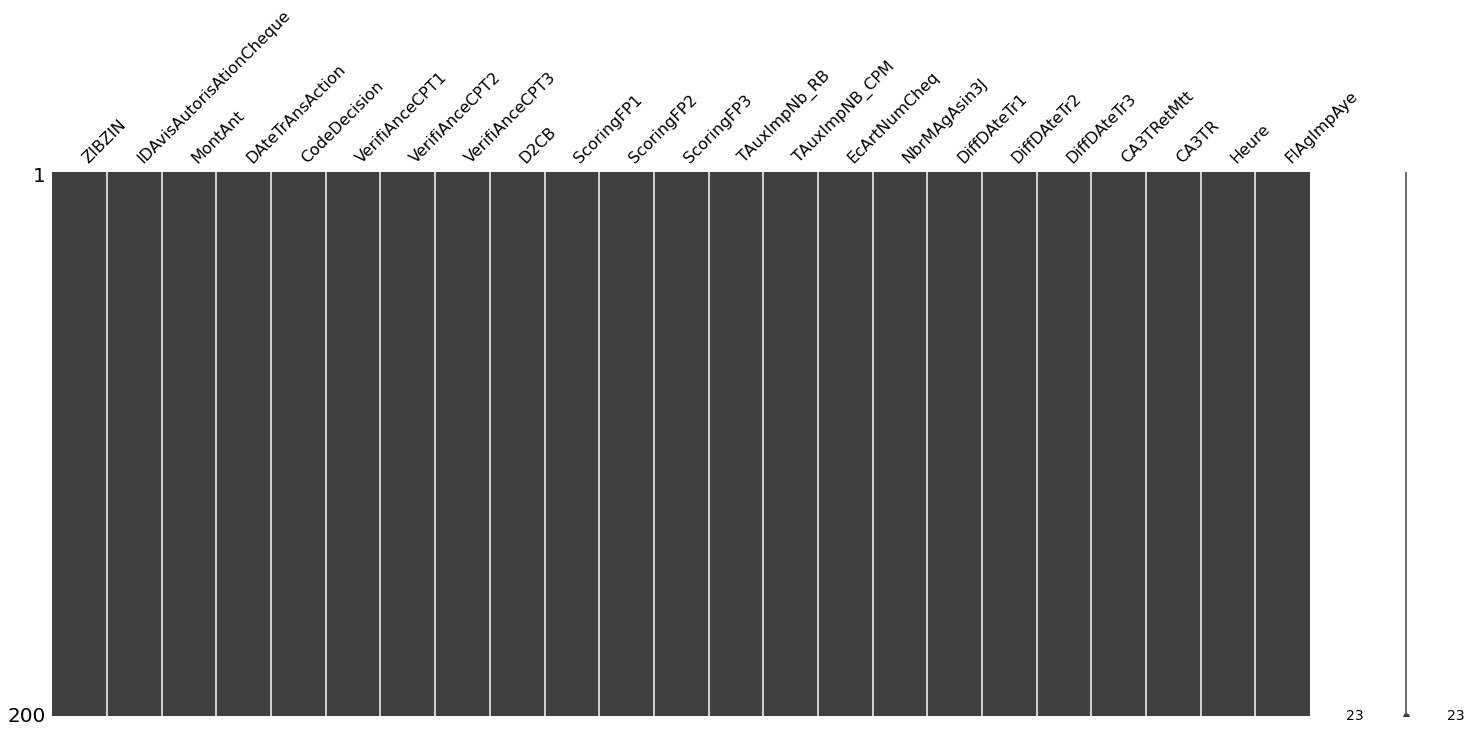

In [6]:
# Matrice des valeurs nulles
mn.matrix(df)

In [29]:
#Nombre de valeurs nulles par variable
print(df.isnull().sum())

ZIBZIN                      0
IDAvisAutorisAtionCheque    0
MontAnt                     0
DAteTrAnsAction             0
CodeDecision                0
VerifiAnceCPT1              0
VerifiAnceCPT2              0
VerifiAnceCPT3              0
D2CB                        0
ScoringFP1                  0
ScoringFP2                  0
ScoringFP3                  0
TAuxImpNb_RB                0
TAuxImpNB_CPM               0
EcArtNumCheq                0
NbrMAgAsin3J                0
DiffDAteTr1                 0
DiffDAteTr2                 0
DiffDAteTr3                 0
CA3TRetMtt                  0
CA3TR                       0
Heure                       0
FlAgImpAye                  0
dtype: int64


Notre jeu de données comporte aucune valeur nulle. Nous allons maintenant pouvoir faire quelques analyses sur nos données.

### 2.3. Analyse univarié

##### Matrice de corrélation

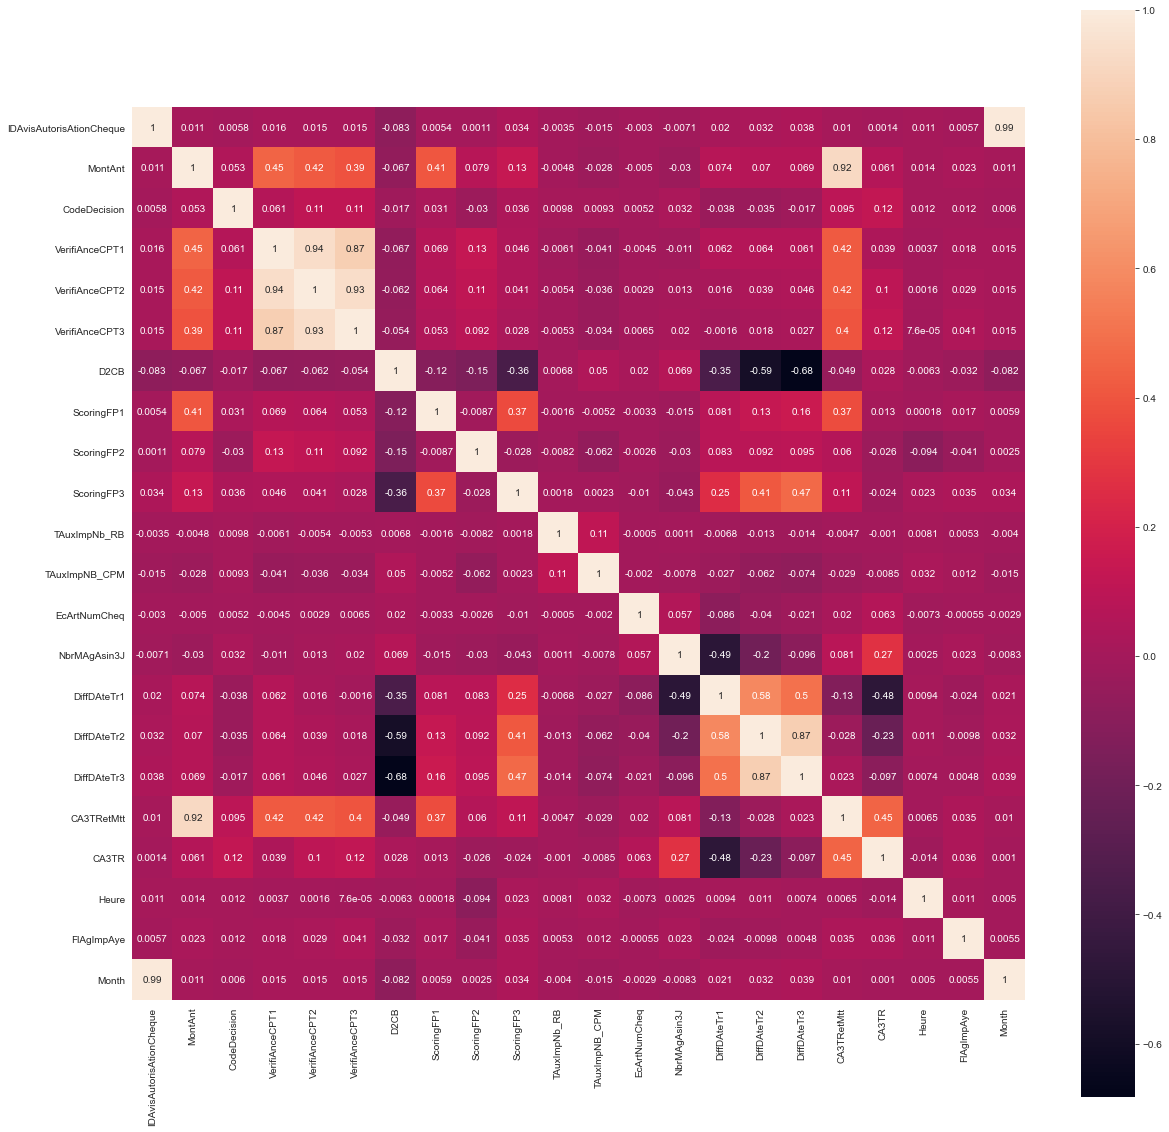

In [18]:
from matplotlib import pyplot
import seaborn as sns
#Matrice de corrélation
sns.set_style("darkgrid")
pyplot.figure(figsize=(20, 20))
sns.heatmap(df.corr(), square=True, annot=True)

Lorsqu'on regarde la matrice de correlation on voit qu'aucune variables est corrélées à notre variables cible. Le plus gros score qu'on observe est 0.041 ce qui est très faible.

##### Description des variables

In [4]:
df.describe()

,IDAvisAutorisAtionCheque,MontAnt,CodeDecision,VerifiAnceCPT1,VerifiAnceCPT2,VerifiAnceCPT3,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,...,TAuxImpNB_CPM,EcArtNumCheq,NbrMAgAsin3J,DiffDAteTr1,DiffDAteTr2,DiffDAteTr3,CA3TRetMtt,CA3TR,Heure,FlAgImpAye
count,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,...,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06
mean,7.356762e+07,5.991771e+01,1.288043e-02,3.991402e-01,4.296752e-01,4.816980e-01,2.477938e+02,3.100542e+00,6.882686e-01,1.769416e-01,...,3.256122e+01,6.724334e+03,1.034200e+00,3.947808e+00,4.234163e+00,4.266234e+00,6.683475e+01,6.917041e+00,5.347306e+04,2.804108e-03
std,1.458268e+06,7.980922e+01,1.682062e-01,5.250070e-01,6.056457e-01,7.339127e-01,2.131088e+02,3.047480e+01,9.336748e+00,5.662696e-01,...,3.475789e+01,1.742520e+05,1.862585e-01,1.078915e+00,5.510923e-01,4.643674e-01,8.929606e+01,3.550385e+01,1.200173e+04,5.287955e-02
min,7.105153e+07,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-4.969986e+01,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,4.745370e-04,1.365741e-03,1.000000e-02,0.000000e+00,1.336000e+03,0.000000e+00
25%,7.232987e+07,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.874265e-03,-2.869431e+00,1.179973e-03,...,1.390821e+01,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,2.792000e+01,0.000000e+00,4.248500e+04,0.000000e+00
50%,7.353719e+07,4.235000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.430000e+02,1.543502e-02,0.000000e+00,2.131271e-03,...,2.526529e+01,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.732000e+01,0.000000e+00,5.488200e+04,0.000000e+00
75%,7.480167e+07,7.205000e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.680000e+02,1.370299e-01,5.289664e+00,1.533859e-02,...,3.927492e+01,0.000000e+00,1.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,8.130000e+01,0.000000e+00,6.390700e+04,0.000000e+00
max,7.619241e+07,1.698534e+04,3.000000e+00,1.500000e+01,4.000000e+01,4.000000e+01,5.510000e+02,1.680000e+04,4.702998e+01,1.839140e+01,...,7.142857e+02,9.993474e+06,1.000000e+01,5.000000e+00,5.000000e+00,5.000000e+00,1.698534e+04,1.060000e+04,8.256400e+04,1.000000e+00


L'ordre de grandeur des variables varie enormement, il faudra penser à standardiser les données pour nos prédictions. 
Regardons le montant de la transaction, qui est une variable importante pour notre problématique. On peut voir que le montant moyen d'une transaction est proche de 60€. Avec la plus petite transaction qui est inférieur à 1€ et la transaction la plus élevé qui est d'environ 17K€. On voit donc un très grand écart entre c'est deux valeurs. La dispersion de cette variable est élevé. Regardons la distribution de cette variable.

[Text(0, 0.5, 'Distribution')]

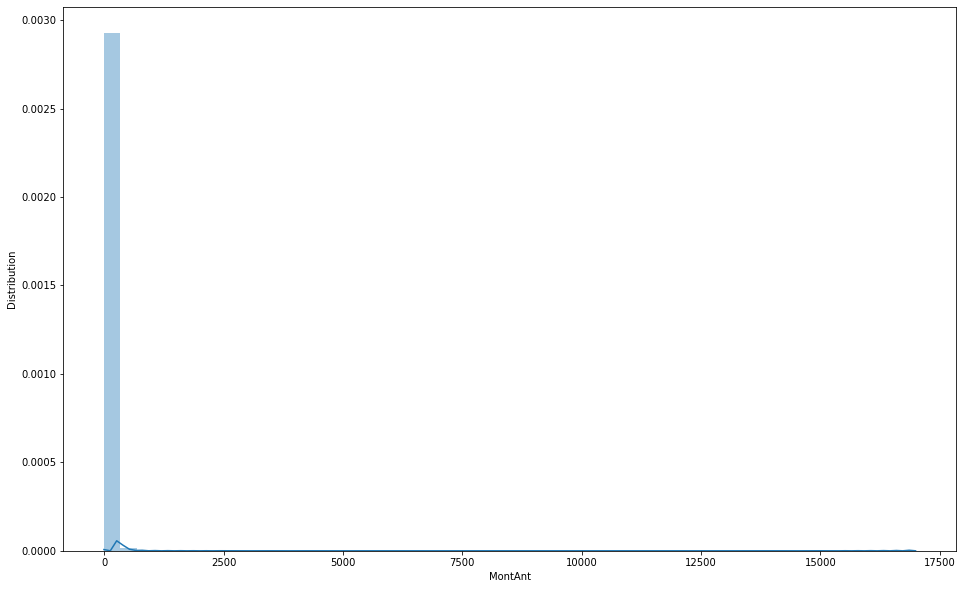

In [10]:
#Distribution de la variable Montant
plt.figure(figsize=(16, 10))
ax = sns.distplot(df["MontAnt"])
ax.set(ylabel="Distribution")  

Quand on regarde la distribution du montant des transactions on voit que la plus part des transactions sont inférieur à 500€. On a très peu de transactions avec une montant très élevé. 
Regardons à présent les deux variables quantitatives discrètes "FlAgImpAye" et "CodeDecision" afin de voir la répartion de ces variables dans cette base.

##### Code Décision : 
Cette variable rappelons-le elle permet de definir si la transaction à été accepter ou refuser soit parce que le client fait partie d'une liste noir soit parce que le système à déjà arrêtés le clients. Cette variable peut prendre 4 valeurs possible (0,1,2 ou 3). Sachant qu'il n'y a normalement aucune valeur 1 dans cette base de données. Nous souhaitons voir la répartition de chacune des valeurs possibles.  

In [20]:
#Répartion de la variable CodeDecision
pd.value_counts(df['CodeDecision'])

0    2218002
2      11360
3       2007
Name: CodeDecision, dtype: int64

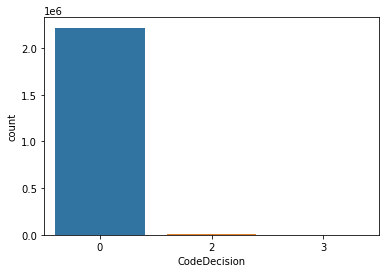

In [28]:
#Barplot
ax = sns.countplot(x="CodeDecision", data=df)

On voit donc que en effet la valeur 1 concernant les clients bon payeurs qui font partie d'une liste blanche ne fait pas partie de cette base. De plus on peut voir que notre jeu de données est composé en majorité de transactions qui ont été aceptées par l'enseigne.

##### Variable cible : FlAgImpAyes

Comme dit précedemment la variable que nous cherchons à prédire est "FlAgImpAyes", il semble donc important de voir la répartition de cette variable, sachant qu'elle peut prendre que 2 valeurs possibles (0 ou 1). 


In [34]:
#Répartion de la variable cible FlAgImpAye en %
print(pd.value_counts(df['FlAgImpAye'])/len(df)) 

0    0.997196
1    0.002804
Name: FlAgImpAye, dtype: float64


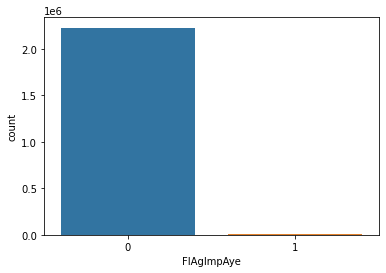

In [13]:
#Barplot
ax = sns.countplot(x="FlAgImpAye", data=df)

On voit donc voit que la classe 1 dite "frauduleuse" est extremement petite par rapport à la classe normale (0). Elle représente 0.28% de notre jeu de données. Plus de 99% de nos données sont donc de la classe normale. Nous sommes dans une environnement extrêmement déséquilibré. Nos prédictions seront faussées et risque de prédire tout le temps la classe majoritaire. Nous devons prendre en compte cet élément pour palier à ça. On va donc procéder à un oversampling pour équilibré nos classes sans perdre des informations importantes sur les classes. Nous allons également tester sur les modèles qui le permette une méthode qui permet de pondérer les données en fonction de sa classe. 

On se demande si le montant des transactions est différent en fonction de la classe. C'est ce que nous allons voir.

##### Relation entre le type de transaction et le montant de celle ci

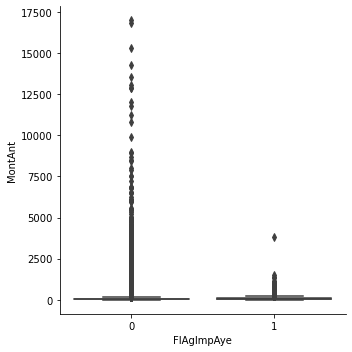

In [39]:
#Relation entre la classe et le montant
sns.catplot(x="FlAgImpAye", y="MontAnt", kind="box", data=df)

Il ne semble pas y avoir une grande différence entre le montant moyen des transaction de ces deux classes. Néanmoins on voit que les transactions les plus élevées sont des transactions qui ne sont pas frauduleuses. Les transactions de la classe frauduleuses sont moins dispersées.

##### Date transaction

Il nous reste une variable importante à regarder de plus près. C'est la variable de la date de transaction (DAteTrAnsAction). Nous allons commencer par la transformer pour quel soit au bon format "datetime".

In [7]:
#Transformation de la date au format datetime
df['DAteTrAnsAction'] = pd.to_datetime(df['DAteTrAnsAction'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231369 entries, 0 to 2231368
Data columns (total 23 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   ZIBZIN                    object        
 1   IDAvisAutorisAtionCheque  int64         
 2   MontAnt                   float64       
 3   DAteTrAnsAction           datetime64[ns]
 4   CodeDecision              int64         
 5   VerifiAnceCPT1            int64         
 6   VerifiAnceCPT2            int64         
 7   VerifiAnceCPT3            int64         
 8   D2CB                      int64         
 9   ScoringFP1                float64       
 10  ScoringFP2                float64       
 11  ScoringFP3                float64       
 12  TAuxImpNb_RB              float64       
 13  TAuxImpNB_CPM             float64       
 14  EcArtNumCheq              int64         
 15  NbrMAgAsin3J              int64         
 16  DiffDAteTr1               float64       
 17  DiffDAte

In [8]:
#Extraction du mois
df['Month']=df['DAteTrAnsAction'].dt.month
a=pd.value_counts(df['Month'])
#Les différents mois present dans la base de données
print(df['Month'].unique())

[ 3  4  5  6  7  8  9 10]


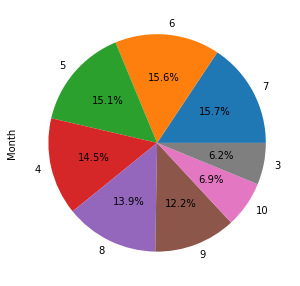

In [6]:
#Répartion par mois
plot = a.plot.pie(y='Month', figsize=(5, 5),autopct='%1.1f%%')

Donc notre base de données répresente 8 mois différents de mars à octobre. Ce graphique nous montre la répartition des transactions en fonction du mois. Le mois qui enregistre le plus de transactions est le mois de juillet. A contrario les mois qui ont le moins d'activité est le mois et mars suivit de près par octobre, ce qui s'explique nottament par le fait que nous n'avons pas les transactions sur le mois complet.

La première étape d'analyse de la base est fini. Nous allons pouvoir passer à la création de nos bases de test et d'entrainement.

## 3. Création des ensembles de données

L'objectif ici est de creer notre base d'apprentissage et de test en fonction de la date de la transaction. Puis à partir de la base d'apprentissage nous créerons deux sous-ensembles. Un ensemble d'entrainement et un ensemble de validation.

### 3.1. Ensembles d'apprentissage et de test

- Notre base d'apprentissage comprendra les transactions ayant eu lieu entre le "2016-03-21" et le "2016-09-19". 
- Notre base de test les transactions ayant eu lieu entre le "2016-09-20" et le "2016-10-19".

In [9]:
#Apprentissage
Apprenti = df.loc[df['DAteTrAnsAction'] < '2016-09-20'] 
#Test
Test = df.loc[df['DAteTrAnsAction'] >= '2016-09-20'] 

Une fois notre base divisé en deux ensembles. On créé notre ensemble de variables explicatives et notre variable cible. 


Nous allons garder seulement les variables qui nous semble les plus utiles. Nous avons donc décidés d'enlever les variables d'identifiants, la variable de date ainsi que l'heure des transactions. 


Nous regroupons ces variables dans une base nommée "training_features" pour la base d'apprentissage et "test_features" pour le test. Dans une base "training_target" et "test_target" nous mettons notre variable cible qui représente la classe de la transaction (FlAgImpAye). 

In [10]:
#Apprentissage
#Variables explicatives
training_features= Apprenti.drop(Apprenti.columns[[0, 1,3,21,22]], axis=1) 
#Variables cible
training_target = Apprenti['FlAgImpAye']

In [11]:
#Test
#Variables explicatives
test_features= Test.drop(Apprenti.columns[[0, 1, 3,21,22]], axis=1) 
#Variable cible
test_target = Test['FlAgImpAye']

### 3.2. Ensembles d'entrainement et de validation
A partir de notre base d'apprentissage on va pouvoir créer notre ensemble d'entrainement et notre ensemble de validation. 
On a dans un premier temps décidé de répartir les données en 70% pour l'entrainement et 30% pour le test. La répartition était donc la suivante : 
- Transaction du 2016-03-21 au 2016-07-22 pour l'ensemble d'entrainement. 
- Transaction du 2016-07-22 au 2016-09-19 pour la base de validation.
Avec cette répartition nous obtenions au maximun une mesure f1 de 13% lors de la phase de validation.


Nous avons cherché à améliorer cette mesure en modifiant notre manière de diviser la base. Nous sommes donc partis sur une répartition en fonction de la date. En prenant 1 mois de transactions pour l'ensemble de validation et le reste pour l'ensemble d'entrainement, soit 5 mois. Cette répartition permet d'obtenir de meilleurs résultats nous avons donc choisit cette option et nous obtenons la répartition suivantes : 
- Transaction du 2016-03-21 au 2016-08-19 pour l'ensemble d'entrainement. 
- Transaction du 2016-08-20 au 2016-09-19 pour la base de validation.

In [12]:
#Entrainement
entrainement = Apprenti.loc[df['DAteTrAnsAction'] < '2016-08-20'] 
#Validation
validation = Apprenti.loc[df['DAteTrAnsAction'] >= '2016-08-20'] 

In [13]:
x_train= entrainement.drop(Apprenti.columns[[0, 1, 3,21,22]], axis=1) 
y_train = entrainement['FlAgImpAye']
x_val= validation.drop(Apprenti.columns[[0, 1, 3,21,22]], axis=1) 
y_val = validation['FlAgImpAye']

In [14]:
#information sur train
print(pd.value_counts(y_train))
print(np.shape(x_train))

0    1673087
1       4454
Name: FlAgImpAye, dtype: int64
(1677541, 19)


## 4. Mesure d'évaluation le F1 Score 

En classification plusieurs mesures peuvent être utiliser pour evaluer la qualité d'un modèle. Par exemple la precision, le rappel, la courbe ROC, l'accuracy ou bien la f-mesure. Toutes ces mesures ne sont pas forcement adaptées à notre problème. 

Par exemple l'accuracy n'est pas une indicateur fiable lorsque nous somme dans un environnement déséquilibré. En effet avec un jeu de données où plus de 99% de nos données appartienne à la première classe si notre algorithme prédit toutes nos transaction comme appartenant à la première classe nous aurons une accuracy très élevée mais pourtant le modèle sera mauvais car il predira toujours la même classe.

La précision permet de calculer la proportion de predictions positives qui sont réellement positives. Permet ainsi de réduire l'erreur de prédiction des transactions frauduleuses.  Le rappel lui nous donne la proportion de données positives qui ont été correctement predites. C'est à dire la part des fraudes qui ont été détecter. 

Dans notre problème il est important de detecter le maximum de fraudes mais il est également important de ne pas prédire des fausses fraudes. En effet accusé un client de fraudes alors que ce n'est pas la cas peut avoir des conséquences. Ainsi pour maximiser la prédiction de fraudes et minimiser l'erreur de prédiction, une mesure existe, c'est la f-mesure.  L'objectif va être de maximiser celle-ci pour obtenir le meilleur modèle.

D'ailleurs, nous pouvons utiliser les measures suivant pour les bases de données imbalance:

- Recall
- Precision
- F1-score
- Area Under ROC curve.


Formulaire:
- Recall = TP / (TP + FN)
- Precision = TP / (TP + FP)
- F1-Score = 2*P*R / (P + R) here P for Precision, R for Recall

## 5. SMOTE OverSampling

Pour réssoudre le problème de classes déséquilibrés nous allons procéder à un ré échantillonage. Il éxiste deux catégories d'échantillonnages : les sous-echantillonnage (undersampling) qui consiste à supprimer des données de la classe majoritaire et sur-echantillonnage (oversampling) qui lui va rajouter des données dans la classe minoritaire. 
Comme nous l'avons vu la classe majoritaire contient plus de 99% des données. Réaliser un undersampling supprimerai alors presque la totalité des données. Ainsi pour garder le maximum de d'information, nous avons décidé de réaliser un oversampling avec la méthode SMOTE.

Le principe de SMOTE est de générer de nouveaux échantillons en combinant les données de la classe minoritaire avec celles de leurs voisins proches. Techniquement, on peut décomposer SMOTE en 5 étapes :

- Choix d’un vecteur caractéristique de notre classe minoritaire que nous appellerons vc ;

- Sélection des k-voisins les plus proches (k=5 par défaut) et choix de l’un d’eux au hasard que l’on appellera pv ;

- Calcul de la différence pour chaque valeur caractéristique (feature value) i, vc[i]-pv[i] et multiplication de celle-ci par un nombre aléatoire entre [0,1];

- Ajout du résultat précédent à la valeur de la caractéristique i du vecteur vc afin d’obtenir un nouveau point (une nouvelle donnée) dans l’espace des caractéristiques ;

- Répétition de ces opérations pour chaque point de données de la classe minoritaire ;

https://beckernick.github.io/oversampling-modeling/

In [15]:
#Réalisation du SMOTE
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [16]:
#Vérification
print(np.shape(x_train_res))
print(pd.value_counts(y_train_res)/len(y_train_res))

(3346174, 19)
1    0.5
0    0.5
Name: FlAgImpAye, dtype: float64


L'algorithme smote est exécuter sur l'algorithme d'entrainement. Notre variable cible est à présent équilibré, nous avons bien 50/50 dans chaque classe et plus de 3 millions de données.

# 6. ACP

Sans SMOTE

In [12]:
print(pd.value_counts(y_train)/len(y_train))

0    0.997388
1    0.002612
Name: FlAgImpAye, dtype: float64


/Users/hoangkhanhle/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0.98, 'Premier plan factoriel')

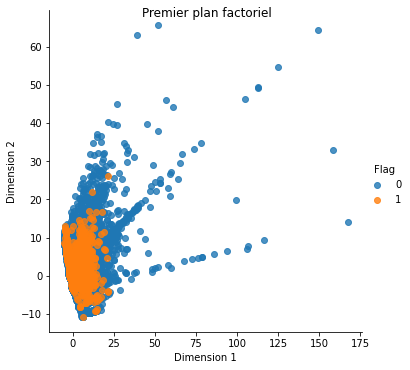

In [41]:
pca = PCA(n_components=2)
sc = StandardScaler() 
X_normalized = sc.fit_transform(x_train)  
components = pca.fit_transform(X_normalized)
# Transformation en DataFrame pandas
fraud_pca_df = pd.DataFrame({
    "Dim1" : components[:,0], 
    "Dim2" : components[:,1], 
    "Flag" : y_train
})
g_pca = sns.lmplot("Dim1", "Dim2", hue = "Flag", data = fraud_pca_df,fit_reg = False)
g_pca.set(xlabel = "Dimension 1", ylabel = "Dimension 2")
g_pca.fig.suptitle("Premier plan factoriel")

Les données ne sont pas très clair à distiguer les classes à cause de nombreux classes. Nous pouvons voir qu'il y a beaucoup plus de classe 0 que classe 1. Les classe sont assez concentré mais aussi mélangé de l'un à l'autre

Avec SMOTE:

/Users/hoangkhanhle/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0.98, 'Premier plan factoriel')

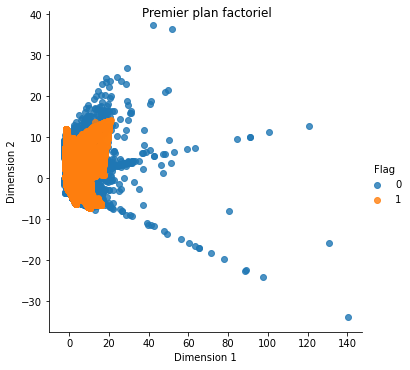

In [30]:
pca = PCA(n_components=2)
sc = StandardScaler() 
X_normalized_res = sc.fit_transform(x_train_res)  
components_res = pca.fit_transform(X_normalized_res) 
# Transformation en DataFrame pandas
fraud_pca_df_res = pd.DataFrame({
    "Dim1" : components_res[:,0], 
    "Dim2" : components_res[:,1], 
    "Flag" : y_train_res
})
g_pca_res = sns.lmplot("Dim1", "Dim2", hue = "Flag", data = fraud_pca_df_res, fit_reg = False)
g_pca_res.set(xlabel = "Dimension 1", ylabel = "Dimension 2")
g_pca_res.fig.suptitle("Premier plan factoriel")

Les classes sont encore dur à observer.

## 7. Algorithmes

Now we can build models using different machine learning algorithms. Before creating a model, we need to find the type of problem statement, which means is supervised or unsupervised algorithms. 

Our problem statement falls under the supervised learning problem means the dataset has a target value for each row or sample in the dataset. 

Supervised machine learning algorithms are two types 

Classification Algorithms
Regression Algorithms
Our problem statement belongs to what type of algorithms? 

Yeah, exactly.

Credit card fraud detection is a classification problem. Target variable values of Classification problems have integer(0,1) or categorical values(fraud, non-fraud). The target variable of our dataset ‘Class’ has only two labels - 0 (non-fraudulent) and 1 (fraudulent).


Pour résoudre notre problème nous avons décidé de tester plusieurs modèles de prédiction afin de trouver le meilleur qui maximisera notre valeur de f1.

Les algorithmes que nous allons appliquer sont :

- La forêt aléatoire (random forest)
- Les K plus proche voisins (k Nearest Neighbor)
- L'arbre de décision (Decision Tree)
- L'analyse discriminent linéaire
- Des modèles ensembliste
- Xgboost
- Modèle de one class classification : isolation forest
    
Pour chacun des algorithmes nous avons tester plusieurs valeurs pour les hyper-paramètres afin de trouver les meilleurs.

### 7.1 Random Forest

Le premier algorithme que nous avons tester est le random forest appelé en français la forêt aléatoire. Il consiste à assembler plusieurs arbres de décision.
Cette algorithme donne la possibilité d'affecter un poid en fonction de la classe. Nous allons donc tester la forêt aléatoire en utilisant les données ré échantillonné puis les données déséquilibrés en rajoutant un poids.

#### 7.1.1 Avec SMOTE


In [17]:
pipeRFS = make_pipeline(StandardScaler(), RandomForestClassifier( max_depth=60,min_samples_leaf=10,
n_estimators=50, n_jobs=-1, random_state=5))
start = time()
pipeRFS.fit(x_train_res, y_train_res) 
end = time()
print("temps de calcul : ",((end-start)/60))

temps de calcul :  2.441199771563212


In [19]:
print(metrics.classification_report(y_val, pipeRFS.predict(x_val)))
print ("Score f1:",f1_score(y_val, pipeRFS.predict(x_val)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    288737
           1       0.17      0.04      0.06       948

    accuracy                           1.00    289685
   macro avg       0.58      0.52      0.53    289685
weighted avg       0.99      1.00      1.00    289685

Score f1: 0.05897658282740677


In [ ]:
print(metrics.classification_report(test_target, RDbest.predict(test_feature)))
print ("Score f1:",f1_score(test_target, RDbest.predict(test_feature)))

Le f1 maximum que l'on a réussi à avoir avec cette algorithme est de 0.06, c'est un score pas très élevé, nous allons essayer de trouver un meilleur modèle.

#### 5.1.2 Sans SMOTE

Ici, nous utilison un random forest sans utiliser les données rééquilibrées avec un smote. On va accorder un poid en fonction de la classe. Pour ce faire on utilise l'option "class_weight" dans notre algortihme. La classe négative, non-fraude (0) a 370 plus de fois que la classe (fraude) 1, donc nous allons mettre "class_weight={0:1, 1:370}"

In [22]:
startRF = time()
RDbest1 = RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:370}, criterion='entropy', max_depth=60,min_samples_leaf=10,
n_estimators=350, n_jobs=-1, random_state=5)
RDbest1.fit(x_train, y_train) 
doneRF = time()

tpsRF = round(doneRF - startRF,3)
print("temps de calcul" , tpsRF/60)

temps de calcul 5.852533333333333


Pour Validation :

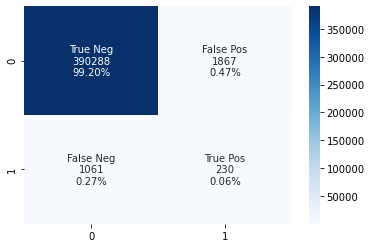

In [31]:
#Matrice de confusion
RDbest_matrix_val = confusion_matrix(y_val, RDbest.predict(x_val))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                RDbest_matrix_val.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     RDbest_matrix_val.flatten()/np.sum(RDbest_matrix_val)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(RDbest_matrix_val, annot=labels, fmt='', cmap='Blues')

In [23]:
print(metrics.classification_report(y_val, RDbest1.predict(x_val)))
print ("Score f1:",f1_score(y_val, RDbest1.predict(x_val)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    288737
           1       0.29      0.11      0.16       948

    accuracy                           1.00    289685
   macro avg       0.64      0.55      0.58    289685
weighted avg       0.99      1.00      1.00    289685

0.1591430757459832


('Score f1:',)

##### Sur TEST :

In [24]:
print(metrics.classification_report(test_target, RDbest1.predict(test_features)))
print("Score f1:",f1_score(test_target,RDbest1.predict(test_features) ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    263288
           1       0.30      0.09      0.14       855

    accuracy                           1.00    264143
   macro avg       0.65      0.54      0.57    264143
weighted avg       0.99      1.00      1.00    264143

Score f1: 0.13755656108597283


On obtient un f1-score ( 0.13) qui est bien mieux que celui avec SMOTE

In [25]:
startRF = time()
RDbest2 = make_pipeline(StandardScaler(),RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:370}, criterion='entropy', max_depth=60,min_samples_leaf=20,
n_estimators=150, n_jobs=-1, random_state=5))
RDbest2.fit(x_train, y_train) 
doneRF = time()

tpsRF = round(doneRF - startRF,3)
print("temps de calcul" , tpsRF/60)

temps de calcul 2.41725


In [26]:
print(metrics.classification_report(test_target, RDbest2.predict(test_features)))
print("Score f1:",f1_score(test_target,RDbest2.predict(test_features) ))
print(metrics.classification_report(y_val, RDbest2.predict(x_val)))
print ("Score f1:",f1_score(y_val, RDbest2.predict(x_val)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    263288
           1       0.15      0.14      0.14       855

    accuracy                           0.99    264143
   macro avg       0.57      0.57      0.57    264143
weighted avg       0.99      0.99      0.99    264143

Score f1: 0.14449127031908487
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    288737
           1       0.15      0.16      0.16       948

    accuracy                           0.99    289685
   macro avg       0.57      0.58      0.58    289685
weighted avg       0.99      0.99      0.99    289685

Score f1: 0.15637860082304528


In [35]:
startRF = time()
RDbest3 = make_pipeline(StandardScaler(),RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:370}, criterion='entropy', max_depth=60,min_samples_leaf=20,
n_estimators=230, n_jobs=-1, random_state=5))
RDbest3.fit(x_train, y_train) 
doneRF = time()

tpsRF = round(doneRF - startRF,3)
print("temps de calcul" , tpsRF/60)

print(metrics.classification_report(test_target, RDbest3.predict(test_features)))
print("Score f1:",f1_score(test_target,RDbest3.predict(test_features) ))
print(metrics.classification_report(y_val, RDbest3.predict(x_val)))
print ("Score f1:",f1_score(y_val, RDbest3.predict(x_val)))

temps de calcul 3.99785
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    263288
           1       0.15      0.14      0.14       855

    accuracy                           0.99    264143
   macro avg       0.57      0.57      0.57    264143
weighted avg       0.99      0.99      0.99    264143

Score f1: 0.14381474710542352
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    288737
           1       0.16      0.16      0.16       948

    accuracy                           0.99    289685
   macro avg       0.58      0.58      0.58    289685
weighted avg       0.99      0.99      0.99    289685

Score f1: 0.15854922279792746


In [36]:
startRF = time()
RDbest4 = make_pipeline(StandardScaler(),RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:370}, criterion='entropy', max_depth=60,min_samples_leaf=20,
n_estimators=225, n_jobs=-1, random_state=5))
RDbest4.fit(x_train, y_train) 
doneRF = time()

tpsRF = round(doneRF - startRF,3)
print("temps de calcul" , tpsRF/60)
print(metrics.classification_report(test_target, RDbest4.predict(test_features)))
print("Score f1:",f1_score(test_target,RDbest4.predict(test_features) ))
print(metrics.classification_report(y_val, RDbest4.predict(x_val)))
print ("Score f1:",f1_score(y_val, RDbest4.predict(x_val)))

temps de calcul 3.746766666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    263288
           1       0.15      0.14      0.14       855

    accuracy                           0.99    264143
   macro avg       0.57      0.57      0.57    264143
weighted avg       0.99      0.99      0.99    264143

Score f1: 0.14285714285714285
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    288737
           1       0.15      0.16      0.16       948

    accuracy                           0.99    289685
   macro avg       0.58      0.58      0.58    289685
weighted avg       0.99      0.99      0.99    289685

Score f1: 0.15756951596292482


In [39]:
startRF = time()
RDbest4 = make_pipeline(StandardScaler(),RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:370}, criterion='entropy', max_depth=100,min_samples_leaf=20,
n_estimators=500, n_jobs=-1, random_state=5))
RDbest4.fit(x_train, y_train) 
doneRF = time()

tpsRF = round(doneRF - startRF,3)
print("temps de calcul" , tpsRF/60)

print(metrics.classification_report(test_target, RDbest4.predict(test_features)))
print("Score f1:",f1_score(test_target,RDbest4.predict(test_features) ))
print(metrics.classification_report(y_val, RDbest4.predict(x_val)))
print ("Score f1:",f1_score(y_val, RDbest4.predict(x_val)))

temps de calcul 8.09125
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    263288
           1       0.16      0.14      0.15       855

    accuracy                           0.99    264143
   macro avg       0.58      0.57      0.57    264143
weighted avg       0.99      0.99      0.99    264143

Score f1: 0.1501240694789082
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    288737
           1       0.16      0.16      0.16       948

    accuracy                           0.99    289685
   macro avg       0.58      0.58      0.58    289685
weighted avg       0.99      0.99      0.99    289685

Score f1: 0.15941269008914524


In [42]:
startRF = time()
RDbest6 = make_pipeline(StandardScaler(),RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:375}, criterion='entropy', max_depth=200,min_samples_leaf=20,
n_estimators=500, n_jobs=-1, random_state=5))
RDbest6.fit(x_train, y_train) 
doneRF = time()

tpsRF = round(doneRF - startRF,3)
print("temps de calcul" , tpsRF/60)

print(metrics.classification_report(test_target, RDbest6.predict(test_features)))
print("Score f1:",f1_score(test_target,RDbest6.predict(test_features) ))
print(metrics.classification_report(y_val, RDbest6.predict(x_val)))
print ("Score f1:",f1_score(y_val, RDbest6.predict(x_val)))

temps de calcul 7.650083333333333
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    263288
           1       0.16      0.14      0.15       855

    accuracy                           0.99    264143
   macro avg       0.58      0.57      0.57    264143
weighted avg       0.99      0.99      0.99    264143

Score f1: 0.14606741573033707
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    288737
           1       0.16      0.16      0.16       948

    accuracy                           0.99    289685
   macro avg       0.58      0.58      0.58    289685
weighted avg       0.99      0.99      0.99    289685

Score f1: 0.15849843587069862


# SMOTE et K Nearest Neighbor

In [16]:
pipeKNN = make_pipeline(StandardScaler(), KNeighborsClassifier())
startKNN = time()
pipeKNN.fit(x_train_res, y_train_res)  
endKNN = time()
doneKNN= (endKNN-startKNN)/60
print(doneKNN)

-3073.963047027588


In [19]:
print(metrics.classification_report(y_val, pipeKNN.predict(x_val)))
print (f1_score(y_val, pipeKNN.predict(x_val)))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    588363
           1       0.01      0.22      0.02      1805

    accuracy                           0.94    590168
   macro avg       0.50      0.58      0.50    590168
weighted avg       0.99      0.94      0.97    590168

0.023012304779933743


# Decision Tree

Le second algorithme que nous avons utilisé en classification est l’arbre de classification. Il permet de prédire une variable cible discrète. Le principe est le même celui de l’arbre de décision, et fonctionne comme l’arbre de régression. L’arbre est construit grâce à un partitionnement récursif des données. Le principe est alors celui de séparer les données via des partitions, qui vont elles-mêmes se séparer à leur tour à mesure que l’on va descendre en profondeur dans l’arbre. Les avantages de cette méthode sont les mêmes que ceux que l’arbre de régression, les résultats obtenus par cette méthode sont très satisfaisants quand on les compare avec le rapide temps de calcul et la faible complexité de l’algorithme.

In [53]:
pipelineDT = make_pipeline(StandardScaler(), DecisionTreeClassifier())

In [52]:
paramsDT = {"decisiontreeclassifier__max_depth": [3,6,9,12, None],
              "decisiontreeclassifier__min_samples_leaf": np.arange(1,9,1),
              "decisiontreeclassifier__criterion": ["gini", "entropy"]}
#params = {'decisiontreeclassifier__max_depth': [3, None]}

In [63]:
sorted(pipeline_steps.get_params().keys())

['decisiontreeclassifier',
 'decisiontreeclassifier__ccp_alpha',
 'decisiontreeclassifier__class_weight',
 'decisiontreeclassifier__criterion',
 'decisiontreeclassifier__max_depth',
 'decisiontreeclassifier__max_features',
 'decisiontreeclassifier__max_leaf_nodes',
 'decisiontreeclassifier__min_impurity_decrease',
 'decisiontreeclassifier__min_impurity_split',
 'decisiontreeclassifier__min_samples_leaf',
 'decisiontreeclassifier__min_samples_split',
 'decisiontreeclassifier__min_weight_fraction_leaf',
 'decisiontreeclassifier__presort',
 'decisiontreeclassifier__random_state',
 'decisiontreeclassifier__splitter',
 'memory',
 'standardscaler',
 'standardscaler__copy',
 'standardscaler__with_mean',
 'standardscaler__with_std',
 'steps',
 'verbose']

In [65]:
gridsearchDT = GridSearchCV(estimator=pipelineDT,
                       param_grid=paramsDT,
                       n_jobs=-1,
                       scoring='f1_micro')
gridsearchDT.fit(x_train_res, y_train_res)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [3, 6, 9, 12,
                                                               None],
                         'decisiontreeclassifier__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8])},
             scoring='f1_micro')

In [66]:
gridsearchDT.best_estimator_.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('decisiontreeclassifier', DecisionTreeClassifier(criterion='entropy'))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy'),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': None,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': 'deprecated',
 'decisiontreeclassifier__random_sta

In [67]:
print ('Validation Results')
print (gridsearchDT.score(x_val, y_val))
print (recall_score(y_val, gridsearchDT.predict(x_val)))
print (f1_score(y_val, gridsearchDT.predict(x_val)))
print ('\nTest Results')
print (gridsearchDT.score(test_features, test_target))
print (recall_score(test_target, gridsearchDT.predict(test_features)))
print (f1_score(test_target, gridsearchDT.predict(test_features)))

Validation Results
0.9832674763796072
0.10027700831024931
0.03536192243821432

Test Results
0.9846446811007674
0.10175438596491228
0.04113475177304965


# Analyse discriminante linéaire

Nous avons décidé de présenter les résultats de l’analyse discriminante linéaire. En effet c’est un modèle relativement simple à mettre en œuvre dont les résultats sont faciles à interpréter. De même, le temps de calcul est plutôt rapide quel que soit la taille des données et est plutôt stable sur des petits échantillons. Pour appliquer cette méthode, deux hyper-paramètres peuvent être utilisés le « solver » et le «shrinkage». Le premier permet de changer la méthode de calcul et le second permet une régularisation lorsque la dimensionnalité augmente.

Création de pipeline

In [47]:
pipelineADL = make_pipeline(StandardScaler(),LinearDiscriminantAnalysis())

On obtient une liste des paramètres qu'on peut tenter dans le gridsearch

In [143]:
sorted(pipelineADL.get_params().keys())

['lineardiscriminantanalysis',
 'lineardiscriminantanalysis__n_components',
 'lineardiscriminantanalysis__priors',
 'lineardiscriminantanalysis__shrinkage',
 'lineardiscriminantanalysis__solver',
 'lineardiscriminantanalysis__store_covariance',
 'lineardiscriminantanalysis__tol',
 'memory',
 'standardscaler',
 'standardscaler__copy',
 'standardscaler__with_mean',
 'standardscaler__with_std',
 'steps',
 'verbose']

In [48]:
paramsADL = {'lineardiscriminantanalysis__solver':['svd', 'lsqr','eigen'],
             'lineardiscriminantanalysis__shrinkage':[None, 'auto'],
             'lineardiscriminantanalysis__tol':[0.0001,0.0002,0.0003]} #Paramètres à tester

In [49]:
tscv = TimeSeriesSplit(n_splits=5)
startADL = time()
#instanciation - recherche des hyperparametres optimaux
gridsearchADL = GridSearchCV(estimator=pipelineADL,
                       param_grid=paramsADL,
                       n_jobs=-1,
                       scoring='f1_micro')
gridsearchADL.fit(x_train_res, y_train_res)
doneADL = time()

In [50]:
)tpsADL = round(doneADL - startADL,3)
print(tpsADL/60)

4.15635


Donc le temps de calcul est environ 3,8 minutes  

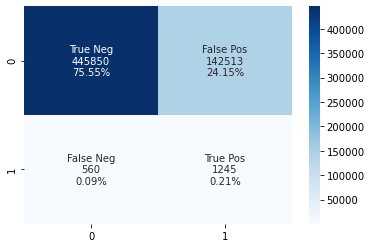

In [142]:
ADL_matrix_val = confusion_matrix(y_val, gridsearchADL.predict(x_val))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                ADL_matrix_val.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     ADL_matrix_val.flatten()/np.sum(ADL_matrix_val)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(ADL_matrix_val, annot=labels, fmt='', cmap='Blues')

Les métriques d'evaluation

In [115]:
print ('Validation Results')
indiceADL=metrics.classification_report(y_val, gridsearchADL.predict(x_val))
indice=report_to_df(indiceADL)
print(indiceADL)

Validation Results
              precision    recall  f1-score   support

           0       1.00      0.76      0.86    588363
           1       0.01      0.69      0.02      1805

    accuracy                           0.76    590168
   macro avg       0.50      0.72      0.44    590168
weighted avg       1.00      0.76      0.86    590168



In [122]:
ADLbest=gridsearchADL.best_estimator_

In [119]:
print('Best Penalty:', gridsearchADL.best_estimator_.get_params()['lineardiscriminantanalysis__shrinkage'])
print('Best C:', gridsearchADL.best_estimator_.get_params()['lineardiscriminantanalysis__tol'])
print('Best solver:', gridsearchADL.best_estimator_.get_params()['lineardiscriminantanalysis__solver'])

Best Penalty: None
Best C: 0.0001
Best solver: svd


On peut voir que le F1 s'arrete à 0.02

### ADL x Random Forest ( Ensemble modeling )

In [146]:
VotingPredictorAR = VotingClassifier(estimators =
                           [('ADL', ADLbest), 
                            ('RD', RDbest)],
                           voting='soft', n_jobs = 4)
VotingPredictorAR = VotingPredictorAR.fit(x_train, y_train)

In [149]:
print ('Validation Results')
indiceAR=metrics.classification_report(y_val, VotingPredictorAR .predict(x_val))
indiceAR=report_to_df(indiceAR)
print(indiceAR)
print(f1_score(y_val, VotingPredictorAR .predict(x_val)))

Validation Results
  Class Name Précision Sensiblité    F1 Fréquence
0          0      1.00       1.00  1.00    588363
1          1      0.09       0.13  0.11      1805
0.1050055617352614


### SVM
Les SVM sont pas adapté les temps d'execution est trop long

In [ ]:
#Test
from sklearn.svm import SVC
pipeSVM = make_pipeline(StandardScaler(), SVC(gamma='auto'))
pipeSVM.fit(x_train_res, y_train_res) 

print ('Validation Results')
#print (clf_rf.score(x_val, y_val))
#print (recall_score(y_val, pipeSVM.predict(x_val)))
print (f1_score(y_val, pipeSVM.predict(x_val)))
#print ('\nTest Results')
#print (clf_rf.score(test_features, test_target))
#print (recall_score(test_target, pipeSVM.predict(test_features)))
print (f1_score(test_target, pipeSVM.predict(test_features)))

#ref: https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

In [ ]:
#bagging svm
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
bagging = make_pipeline(StandardScaler(), BaggingClassifier(SVC(), max_samples=0.5, max_features=0.5))
bagging.fit(x_train_res, y_train_res)
print ('Validation Results')
print (f1_score(y_val, bagging.predict(x_val)))

### xgboost 

In [29]:
#xgboost

# avec cross_val_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
startboost = time()

xg_clas = make_pipeline(StandardScaler(),xgb.XGBClassifier(objective='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5,  alpha = 10, n_estimators = 10))

#preds = xg_clas.predict(x_val)
tscv = TimeSeriesSplit(n_splits=5)
results = cross_val_score(xg_clas,x_train_res,y_train_res, cv=tscv, scoring='f1_micro')
print ('Validation croisé')
print("resultat validation croisé:", results)
print("f1 mesure: %.2f%% " % (results.mean()*100))

xg_clas.fit(x_train_res,y_train_res)
print ('Validation Results')
print (f1_score(y_val, xg_clas.predict(x_val)))

doneboost = time()
tpsADL = round(doneboost - startboost,3)
print(tpsADL/60)

###Resultat###

#Validation croisé
#resultat validation croisé: [0.99740509 0.99714298 0.00784369 0.40749203 0.63242978]
#f1 mesure: 60.85% 
#resultat validation : 0.01957109040189375

C:\Users\paupa\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:00:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\paupa\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:00:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\paupa\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:00:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\paupa\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:00:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\paupa\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation croisé
resultat validation croisé: [0.99740509 0.99714298 0.00784369 0.40749203 0.63242978]
f1 mesure: 60.85% 


C:\Users\paupa\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:01:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation Results
0.01957109040189375
1.0860333333333334


In [23]:
# avec gridschearchcv
#Trop LONG
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
startboost = time()
params = {
        'gamma': [0.5, 1, 2],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5]
        }
tscv = TimeSeriesSplit(n_splits=5)
model  =  xgb.XGBClassifier()

best_boost = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring="f1",
        n_jobs=None,
        cv=tscv
    )

best_boost.fit(x_train_res,y_train_res)
print ("f1 mesure: %.2f%% " % (f1_score(y_val, xg_clas.predict(x_val))))
print('meilleur paramètres :',best_boost.best_params_)
print('meilleur paramètres :',best_boost.best_score_)
doneboost = time()

tpsADL = round(doneboost - startboost,3)
print(tpsADL/60)

[15:52:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:29:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:33:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:18:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:21:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:16:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:17:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:21:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

KeyboardInterrupt: 

In [42]:
#xgboost sans SMOTE
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
startboost = time()
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
# define model
model = make_pipeline(StandardScaler(),xgb.XGBClassifier(objective='binary:logistic',max_depth = 6,  alpha = 4, n_estimators = 10, scale_pos_weight=estimate))
# evaluate model
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(model,x_train, y_train,scoring='f1_micro', cv=tscv, n_jobs=-1)
print ('Validation croisé')
print("resultat validation croisé:", scores)
print('Mean f1: %.5f' % scores.mean())

model.fit(x_train,y_train)
print ('Validation Results')
print (f1_score(y_val, model.predict(x_val)))




doneboost = time()

tpsADL = round(doneboost - startboost,3)
print(tpsADL/60)

PicklingError: Could not pickle the task to send it to the workers.

### One class Classification Isolation forest

In [39]:
from sklearn.metrics import f1_score
from sklearn.ensemble import IsolationForest

start = time()
# define outlier detection model
model = make_pipeline(StandardScaler(),IsolationForest(contamination='auto'))
trainX = x_train[y_train==0]
model.fit(trainX)
ypred = model.predict(x_val)
y_val[y_val==1] = -1 
y_val[y_val==0]=1
score = f1_score(y_val,ypred, pos_label=-1)
print('F1 Score: %.3f' %score)
matrix= confusion_matrix(y_val, ypred)
print(matrix)

done = time()

tpsADL = round(done - start,3)
print(tpsADL/60)

F1 Score: 0.162
[[ 52062 538106]
 [     0      0]]
0.97105


## Bonus

https://www.kaggle.com/currie32/predicting-fraud-with-tensorflow

Nous voudrons maximiser le chiffre d'affaire 

https://www.kaggle.com/currie32/predicting-fraud-with-tensorflow

- si on accepte une bonne transaction (TN) : le chiffre d’affaire généré est égal au montant de la transaction f(m) = m
- si on accepte une mauvaise transaction (FN) : le chiffre d’affaire perdu est proportionnel au montant à f(m) = m(1 − exp(-m))
Plus le montant de la transaction est élevé,
plus la perte est importante.
- lorsque vous refusez une bonne transaction (FP) : vous générez un chiffre d’affaire égal à 80% du montant de la transaction, f(m) = 0.8m
- lorsque vous refusez une transaction frauduleuse, le chiffre d’affaire est nul f(m) = 0

On a le formule de chiffre d'affaire :

CA = TN -FN*(1-exp(-FN))+0.8*FP+0*TP

### Analyse Univarié

On va diviser le bdd en Fraud et Normal :

In [ ]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape


### Caculer le CA

Le CA origin est caculé basé sur tous les transactions normaux 

In [69]:
b=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()
CAorigin = np.sum(b[thttp://localhost:8892/notebooks/Desktop/School/Master%202/Big%20Data/%08ProjetFraud/BIG%20DATA.ipynb#Caculer-le-CAest_target==0])
print(CAorigin)

15436477.790000001


On calcule le lost sur le train 

In [67]:
a=x_train['MontAnt'].to_numpy()
a=(1-y_train.to_numpy())*0.2*a + y_train.to_numpy()*a*(1-np.exp(-a))
print(a)
print(sum(a))

[ 8.034  4.     7.    ...  8.438 10.8    6.74 ]
20432998.580690492


Donc on essaie de fit le meilleur modele avec sample_weight = lost

In [68]:
startRF = time()
RDbest6 = make_pipeline(StandardScaler(),RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:375}, criterion='entropy', max_depth=200,min_samples_leaf=20,
n_estimators=500, n_jobs=-1, random_state=5))
RDbest6.fit(x_train, y_train, sample_weight= a) 
doneRF = time()

tpsRF = round(doneRF - startRF,3)
print("temps de calcul" , tpsRF/60)

print(metrics.classification_report(test_target, RDbest6.predict(test_features)))
print("Score f1:",f1_score(test_target,RDbest6.predict(test_features) ))
print(metrics.classification_report(y_val, RDbest6.predict(x_val)))
print ("Score f1:",f1_score(y_val, RDbest6.predict(x_val)))

ValueError: Pipeline.fit does not accept the sample_weight parameter. You can pass parameters to specific steps of your pipeline using the stepname__parameter format, e.g. `Pipeline.fit(X, y, logisticregression__sample_weight=sample_weight)`.

On a le resultat final 

In [55]:
# Loss = a
a=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()


a=(1-test_target.to_numpy())*0.2*a + test_target.to_numpy()*a*(1-np.exp(-a))
print(a)

# Print loss a 
print(sum(a))

b=df.loc[df['DAteTrAnsAction'] >= '2016-09-20','MontAnt'].to_numpy()
print(b)
CA=np.sum(b[test_target==0])-np.sum(((RDbest4.predict(test_features)-test_target)**2)*a)
print(CA)

[ 9.082 12.412  3.286 ... 37.302  7.708  2.786]
3167961.0491506224
[ 45.41  62.06  16.43 ... 186.51  38.54  13.93]
15354240.376848942


Donc notre resultat est environ 80k$ moins que par rapport le CA original

## Conclusion

# Exporter and save 

In [121]:
  #%notebook '/Users/hoangkhanhle/Desktop/School/Master 2/Big Data/ProjetFraud/BIG DATA.ipynb'